# Objective

**Avocado Prices**

Predict Avocado Prices, depending on different features.

Data: https://www.kaggle.com/datasets/neuromusic/avocado-prices

**Data Explananion:**

The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

|  Date | The date of the observation |
| :---: | :-------------------------: |
| AveragePrice| the average price of a single avocado |
| type | conventional or organic |
| year | the year |
| Region | the city or region of the observation |
| Total Volume | Total number of avocados sold |
| 4046 | Total number of avocados with PLU 4046 sold |
| 4225 | Total number of avocados with PLU 4225 sold |
| 4770 | Total number of avocados with PLU 4770 sold |

# Setup

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import gaussian_kde

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import optuna
from optuna.visualization import plot_parallel_coordinate

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

seed = 42
np.random.seed(seed)

/home/frauke/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing

## Read the Data

In [2]:
df = pd.read_csv("../data/avocado.csv")
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
df.tail()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
18248,11,2018-01-07,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


**Notes:**
* Delete column```Unnamed``` 
* Make column names consistent: lower case and no spaces
* No missing values
* ```type``` and ```region``` are categorical variables
* ```Average Price``` is variable to predict
* Sort dataframe for ```Date``` 

In [5]:
df["Date"].nunique()

169

In [6]:
df = df.sort_values(by="Date").reset_index(drop=True)
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
1,51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
2,51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
3,51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
4,51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


In [7]:
# delete "Unnamed"
del df["Unnamed: 0"]

In [8]:
# Make column names consistent: lower case and no spaces
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [9]:
df.head()

,date,averageprice,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,region
0,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
1,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
2,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
3,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
4,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


In [10]:
# define categorical and numerical columns
categorical = ["type", "region", "year"]
numerical =  ["total_volume", "4046", "4225", "4770", "total_bags","small_bags", "xlarge_bags"]              

In [11]:
# How many types and regions are there?
print("type:\t", len(df["type"].unique()))
print("region:\t", len(df["region"].unique()))

type:	 2
region:	 54


In [12]:
df["region"].unique()

array(['Southeast', 'Chicago', 'HarrisburgScranton', 'Pittsburgh',
       'Boise', 'WestTexNewMexico', 'LosAngeles', 'LasVegas', 'Atlanta',
       'DallasFtWorth', 'MiamiFtLauderdale', 'Plains', 'StLouis',
       'Syracuse', 'Midsouth', 'Sacramento', 'Boston', 'Charlotte',
       'Spokane', 'Albany', 'Houston', 'SouthCarolina', 'SanFrancisco',
       'TotalUS', 'RaleighGreensboro', 'BuffaloRochester',
       'NorthernNewEngland', 'GrandRapids', 'Denver', 'SanDiego',
       'BaltimoreWashington', 'Roanoke', 'RichmondNorfolk', 'Northeast',
       'SouthCentral', 'GreatLakes', 'Louisville', 'Seattle',
       'CincinnatiDayton', 'NewYork', 'NewOrleansMobile', 'Indianapolis',
       'Jacksonville', 'Columbus', 'Detroit', 'Philadelphia',
       'PhoenixTucson', 'Nashville', 'Portland', 'HartfordSpringfield',
       'Tampa', 'Orlando', 'West', 'California'], dtype=object)

In [13]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print("unique values:", df[col].nunique())
    if df[col].dtype == "float64":
        print("mean:", df[col].mean())
    print()

date
['2015-01-04' '2015-01-11' '2015-01-18' '2015-01-25' '2015-02-01']
unique values: 169

averageprice
[1.75 1.49 1.68 1.52 1.64]
unique values: 259
mean: 1.4059784097758845

total_volume
[27365.89 17723.17  2896.72 54956.8   1505.12]
unique values: 18237
mean: 850644.0130089284

4046
[9.30734e+03 1.18935e+03 1.61680e+02 3.01304e+03 1.27000e+00]
unique values: 17702
mean: 293008.42453066073

4225
[ 3844.81 15628.27   206.96 35456.88  1129.5 ]
unique values: 18103
mean: 295154.56835607265

4770
[  615.28     0.    1561.7  15267.89 64225.78]
unique values: 12071
mean: 22839.735992657283

total_bags
[13598.46   905.55  2528.08 14925.18   374.35]
unique values: 18097
mean: 239639.20205984

small_bags
[13061.1    905.55  2528.08 11264.8    186.67]
unique values: 17321
mean: 182194.6866957095

large_bags
[ 537.36    0.   3660.38  187.68 2811.54]
unique values: 15082
mean: 54338.088144556066

xlarge_bags
[   0.   2950.53    6.8  1034.22    6.16]
unique values: 5588
mean: 3106.426507205878



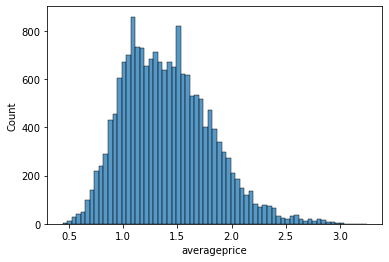

In [14]:
# plot histogram of price
sns.histplot(df["averageprice"]);

**Notes:**
* The price is close to a normal distribution (no long tail), data does not need to be transformed

## Data Preparation
* Define train, valiidation and test splits
* Seperate the price variable

In [15]:
# train, val, test split - CONSIDER TIME
df_train_full, df_test = train_test_split(df, test_size=0.2, shuffle=False, random_state=seed)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, shuffle=False, random_state=seed)

In [16]:
print(f"train_full length {len(df_train_full)}, test length {len(df_test)}")
print(f"train length {len(df_train)}, val length {len(df_val)}")

train_full length 14599, test length 3650
train length 10949, val length 3650


In [17]:
# reset index
df_train_full = df_train_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
# define y
y_train_full = df_train_full["averageprice"].values
y_train = df_train["averageprice"].values
y_val = df_val["averageprice"].values
y_test = df_test["averageprice"].values

In [19]:
# delete "averageprice" from the dataframe
del df_train_full["averageprice"]
del df_train["averageprice"]
del df_val["averageprice"]
del df_test["averageprice"]

In [20]:
df_train.head()

,date,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,region
0,2015-01-04,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
1,2015-01-04,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
2,2015-01-04,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
3,2015-01-04,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
4,2015-01-04,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


# EDA

* Consider the train and validation dataset

**The Target Variable**

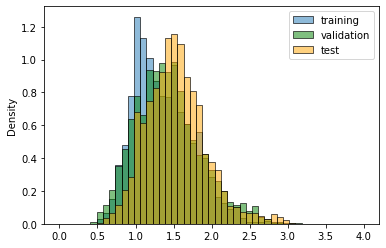

In [21]:
# plot distributions of price - train, val and test
bins = np.linspace(0,4,50)
sns.histplot(y_train, label="training", alpha=0.5, bins=bins, stat="density")
sns.histplot(y_val, color="green", label="validation", alpha=0.5, bins=bins, stat="density")
sns.histplot(y_test, color="orange", label="test", alpha=0.5, bins=bins, stat="density")
plt.legend();

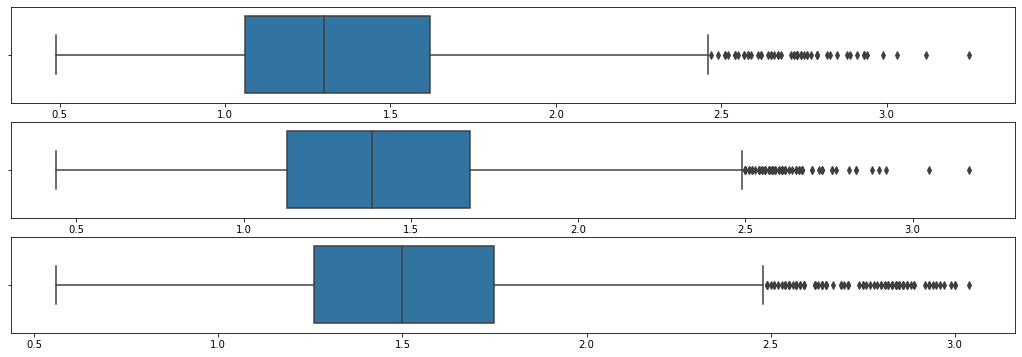

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(18, 6))
for i, n in enumerate([y_train, y_val, y_test]):
    sns.boxplot(x=n, ax=axes[i])

**Notes:**
* validation and test se have similar distributions
* train set distribution is a bit shifted compared to the others
* train, validation and test boxplots are shifted

**Some Statistics**

In [23]:
df_train[numerical].describe()

,total_volume,4046,4225,4770,total_bags,small_bags,xlarge_bags
count,1.094900e+04,1.094900e+04,1.094900e+04,1.094900e+04,1.094900e+04,1.094900e+04,10949.000000
mean,8.229171e+05,2.901533e+05,3.072913e+05,2.735585e+04,1.981167e+05,1.545472e+05,2278.159606
std,3.343323e+06,1.251473e+06,1.253328e+06,1.250415e+05,8.209527e+05,6.389088e+05,14743.713972
min,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,8.914060e+03,9.063300e+02,2.965040e+03,0.000000e+00,2.887400e+03,1.526660e+03,0.000000
50%,9.459167e+04,7.762240e+03,2.885830e+04,2.500000e+02,3.056130e+04,2.048302e+04,0.000000
75%,4.215291e+05,1.089791e+05,1.554690e+05,9.451980e+03,9.260253e+04,7.221214e+04,24.120000
max,5.228870e+07,1.893304e+07,2.047057e+07,2.546439e+06,1.269811e+07,9.967538e+06,551693.650000


In [24]:
df_val[numerical].describe()

,total_volume,4046,4225,4770,total_bags,small_bags,xlarge_bags
count,3.650000e+03,3.650000e+03,3.650000e+03,3.650000e+03,3.650000e+03,3.650000e+03,3650.000000
mean,9.250113e+05,3.055750e+05,2.888577e+05,1.806557e+04,3.125101e+05,2.335533e+05,4699.666096
std,3.719207e+06,1.319691e+06,1.161588e+06,8.002102e+04,1.220447e+06,9.228489e+05,22398.430220
min,5.150100e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.064500e+02,0.000000e+00,0.000000
25%,1.352157e+04,8.505200e+02,3.558390e+03,0.000000e+00,7.145885e+03,3.776287e+03,0.000000
50%,1.289317e+05,9.583005e+03,3.365901e+04,1.703300e+02,5.393461e+04,3.563683e+04,0.000000
75%,4.647101e+05,1.222705e+05,1.479730e+05,4.288215e+03,1.382516e+05,9.962838e+04,631.595000
max,6.103446e+07,2.274362e+07,2.032816e+07,1.664383e+06,1.629830e+07,1.256716e+07,377661.060000


**Boxplots of numerical Variables**

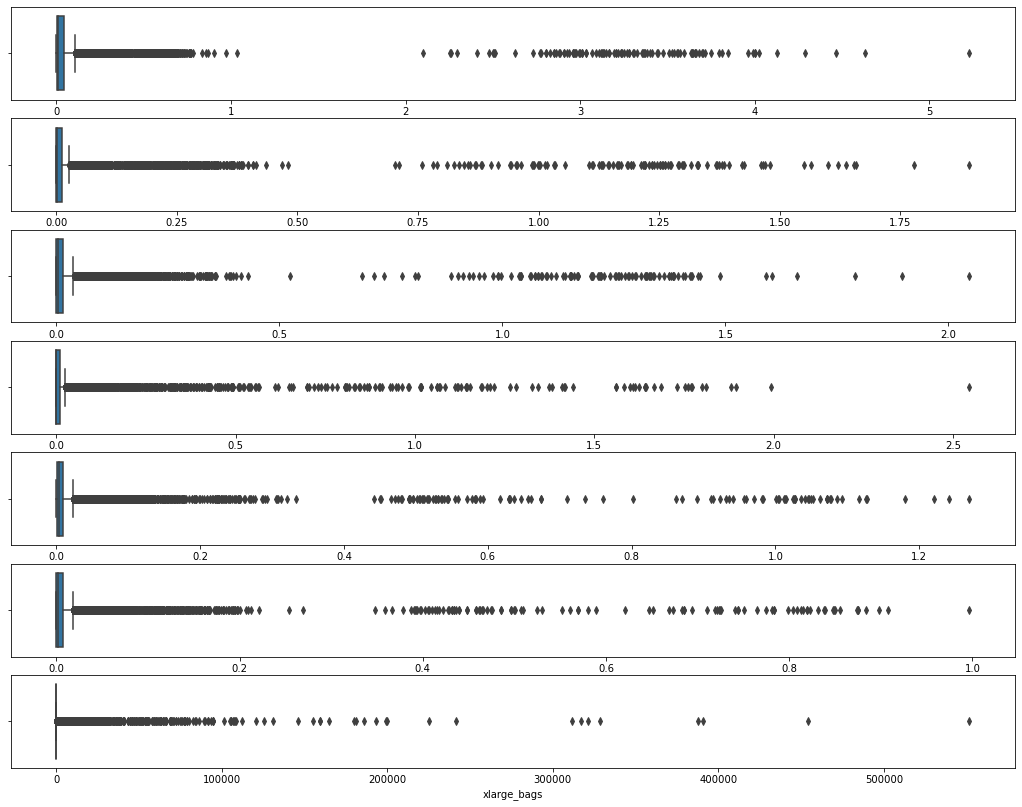

In [25]:
# Boxplots of numerical variables
fig, axes = plt.subplots(len(numerical), 1, figsize=(18, 2*len(numerical)))
for i, n in enumerate(numerical):
    sns.boxplot(x=df_train[n], ax=axes[i])

**Notes:**
* All numerical variables have a lot of large outliers to te right 

**Correlations in training data**

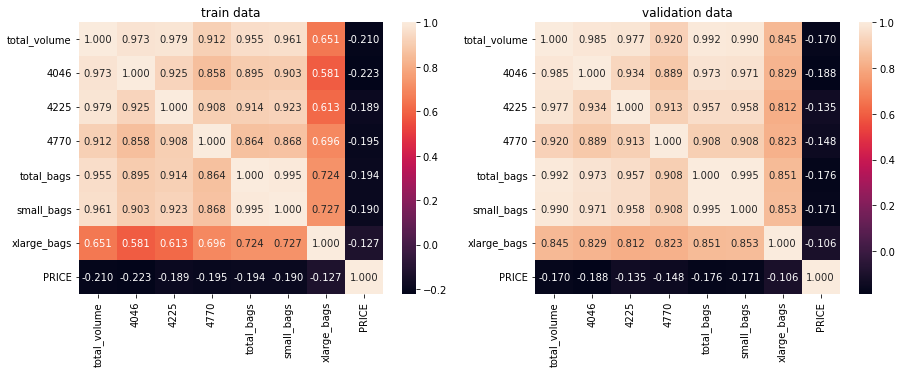

In [26]:
# correlation matrix 
fig, axes = plt.subplots(1, 2, figsize=(15,5))
df_train_y = pd.concat([df_train[numerical], pd.DataFrame(y_train, columns=["PRICE"])], axis=1)
sns.heatmap(df_train_y.corr(), annot=True, fmt=".3f", ax=axes[0])
axes[0].set_title("train data")
df_val_y = pd.concat([df_val[numerical], pd.DataFrame(y_val, columns=["PRICE"])], axis=1)
sns.heatmap(df_val_y.corr(), annot=True, fmt=".3f", ax=axes[1])
axes[1].set_title("validation data");

**Notes:**
* the year seems is not correlated with the other variables
* total volume is higly correlated with ```4046```, ```4225```, ```total_bags```, and ```small_bags```
* The average price ("PRICE") has low correlation with all variables

**Avocados per year**

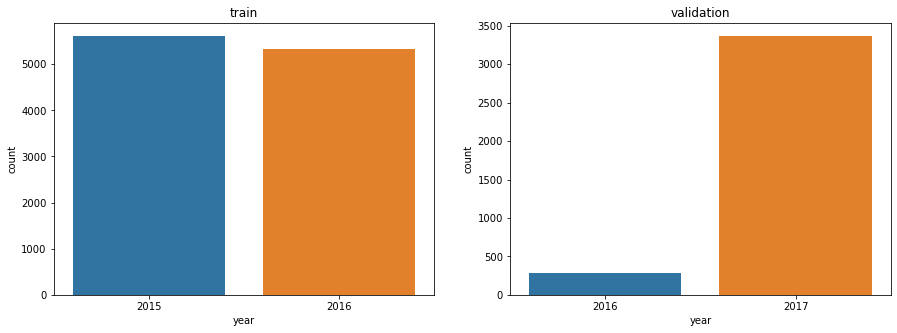

In [27]:
# Number of avocados per year
fig, axes = plt.subplots(1, 2, figsize=(15,5))
df_regions = df_train["year"].value_counts()
sns.countplot(x="year", data = df_train, ax=axes[0])
axes[0].set_title("train")

df_regions = df_val["year"].value_counts()
sns.countplot(x="year", data = df_val, ax=axes[1])
axes[1].set_title("validation");

**Notes:**
* As date only the year is given, no entire date, different prices can belong to one date, no continous time series

**Analyse ```region```**

In [28]:
# mean price per region
df_train_y = pd.concat([df_train["region"], pd.DataFrame(y_train, columns=["PRICE"])], axis=1)
df_mean_price_region = df_train_y.groupby("region").mean()
df_mean_price_region

,PRICE
region,
Albany,1.531133
Atlanta,1.300443
BaltimoreWashington,1.474158
Boise,1.265369
Boston,1.446139
BuffaloRochester,1.515714
California,1.324703
Charlotte,1.538325
Chicago,1.480493


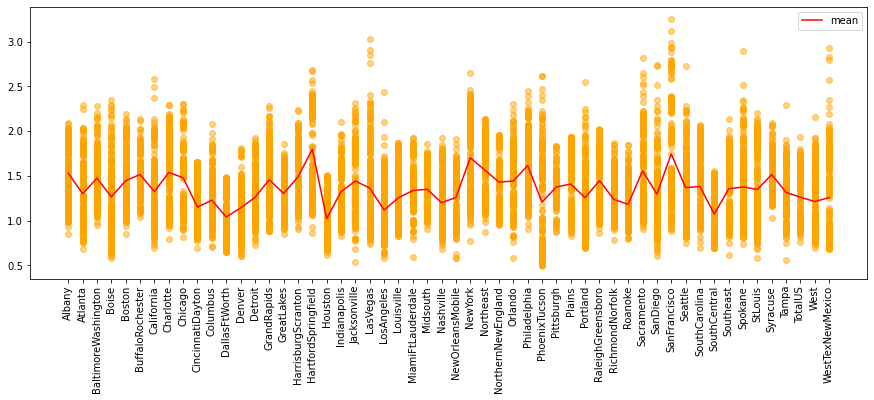

In [29]:
# price depending on region
df_train_y = pd.concat([df_train["region"], pd.DataFrame(y_train, columns=["PRICE"])], axis=1).sort_values("region")
plt.subplots(1, 1, figsize=(15,5))
plt.scatter(df_train_y["region"], df_train_y["PRICE"], alpha=0.5, c="orange")
plt.xticks(rotation=90)
plt.plot(df_mean_price_region, c="red", label="mean")
plt.legend();

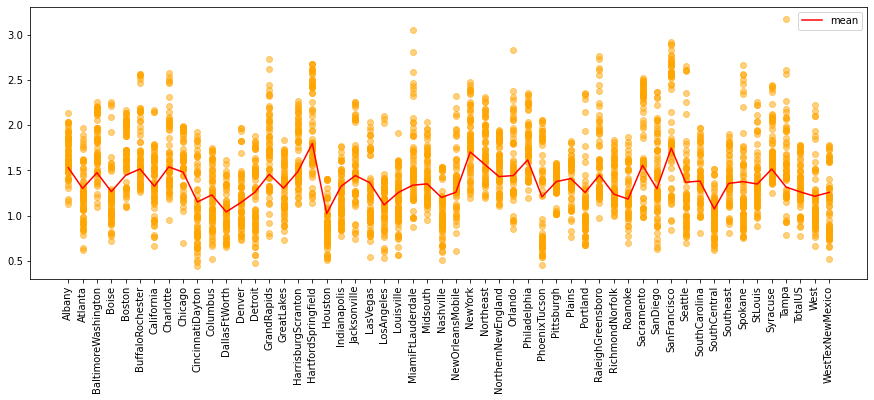

In [30]:
df_val_y = pd.concat([df_val["region"], pd.DataFrame(y_val, columns=["PRICE"])], axis=1).sort_values("region")
plt.subplots(1, 1, figsize=(15,5))
plt.scatter(df_val_y["region"], df_val_y["PRICE"], alpha=0.5, c="orange")
plt.xticks(rotation=90)
plt.plot(df_mean_price_region, c="red", label="mean")
plt.legend();

**Average Price over time per time** 

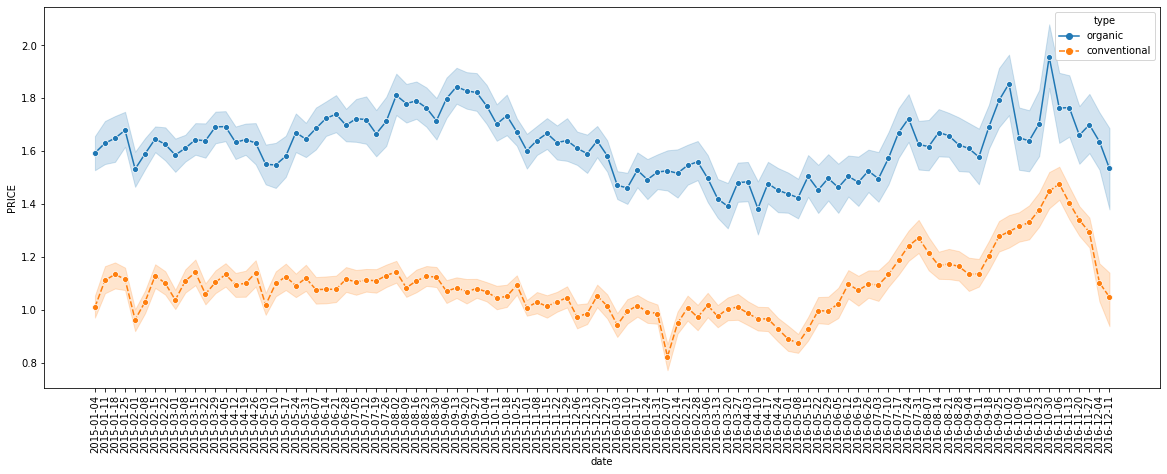

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(20,7))
df_tmp = pd.concat([df_train[["date", "type"]], pd.DataFrame(y_train, columns=["PRICE"])], axis=1)
sns.lineplot(data=df_tmp, x='date', y='PRICE', hue='type', style='type', markers=['o', 'o'])
plt.xticks(rotation=90);

In [32]:
# Number of avocados per region (total_volume)
df_volume_per_region_train = df_train.groupby("region")["total_volume"].sum().sort_values(ascending=False)
df_volume_per_region_train = pd.DataFrame(df_volume_per_region_train).reset_index()
df_volume_per_region_train.head()

,region,total_volume
0,TotalUS,3.414832e+09
1,West,6.374166e+08
2,California,6.113478e+08
3,SouthCentral,5.781117e+08
4,Northeast,4.116969e+08


In [33]:
df_volume_per_region_val = df_val.groupby("region")["total_volume"].sum().sort_values(ascending=False)
df_volume_per_region_val = pd.DataFrame(df_volume_per_region_val).reset_index()
df_volume_per_region_val.head()

,region,total_volume
0,TotalUS,1.257882e+09
1,West,2.416958e+08
2,California,2.264580e+08
3,SouthCentral,2.251192e+08
4,Northeast,1.541416e+08


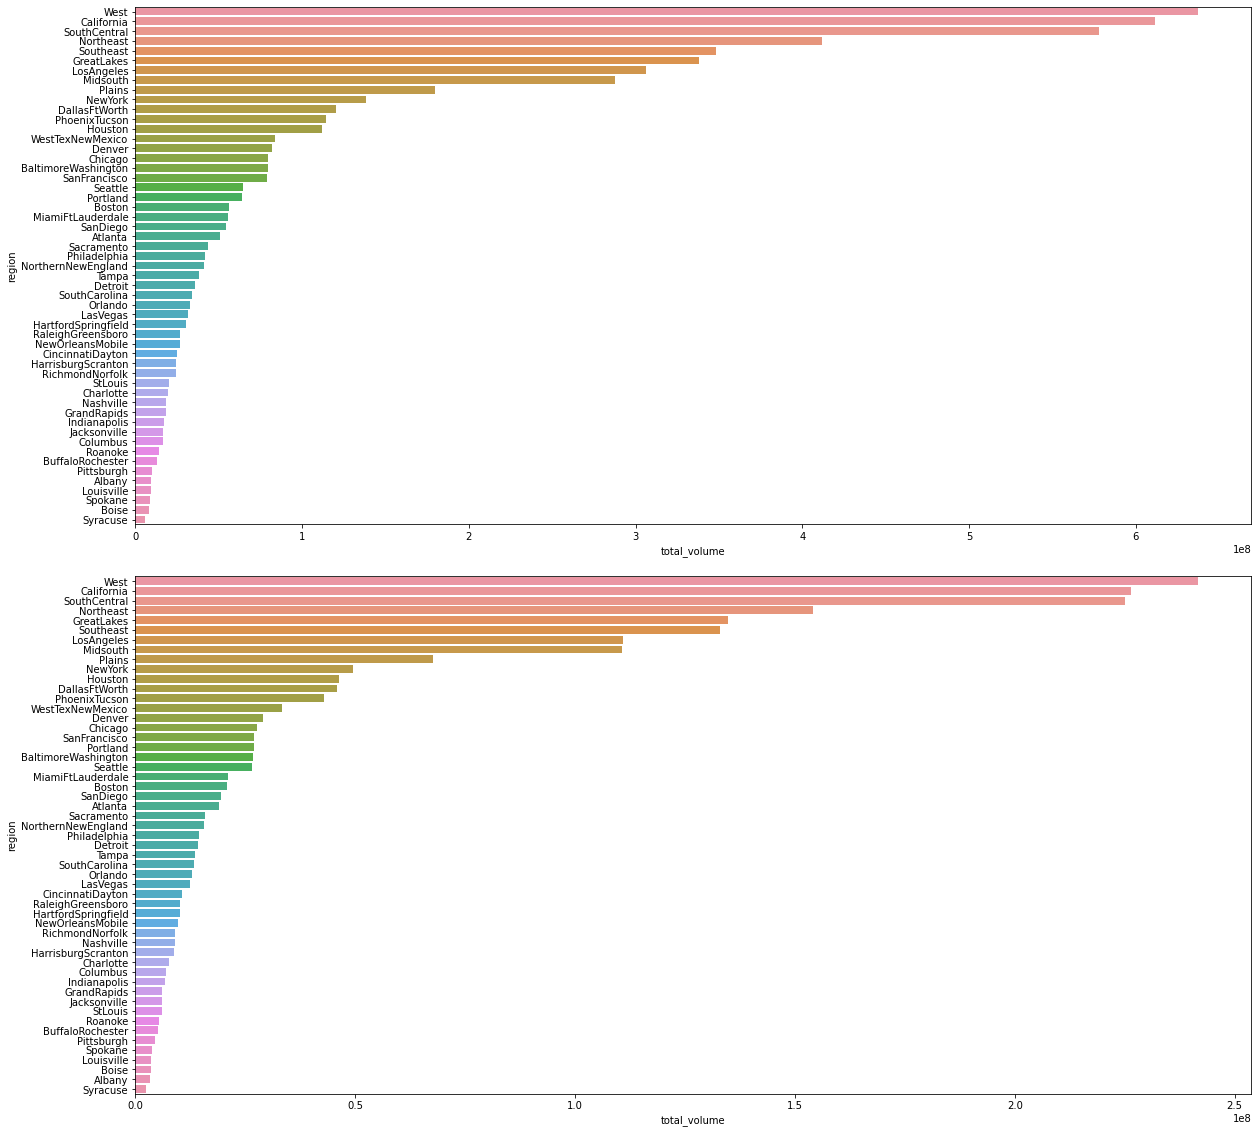

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(20,20))
plt.subplots_adjust(hspace = .1)
sns.barplot(x="total_volume", y=df_volume_per_region_train["region"].iloc[1:], data=df_volume_per_region_train, ax=axes[0])

sns.barplot(x="total_volume", y=df_volume_per_region_val["region"].iloc[1:], data=df_volume_per_region_val, ax=axes[1]);

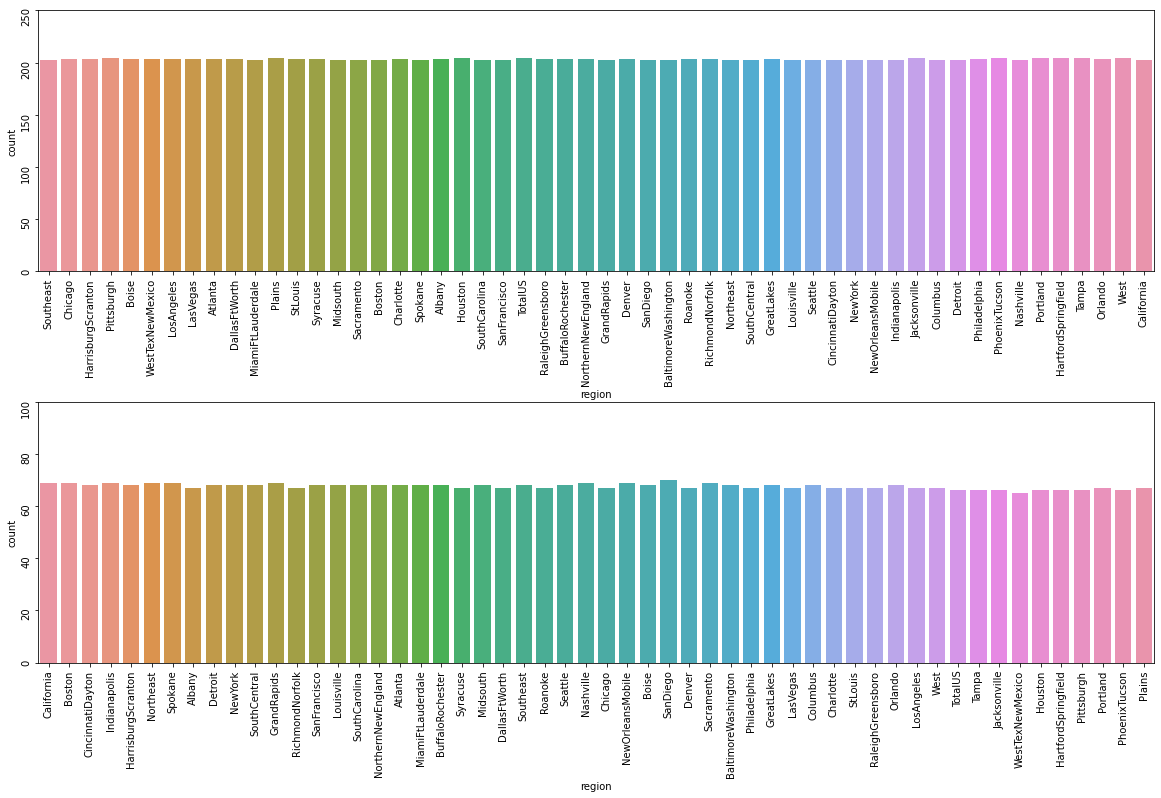

In [35]:
# Entries per region
fig, axes = plt.subplots(2, 1, figsize=(20,12))
plt.subplots_adjust(hspace = .5)
df_regions = df_train["region"].value_counts()
axes[0].set_ylim(0,250)
axes[0].tick_params(labelrotation=90)
sns.countplot(x="region", data = df_train, ax=axes[0]);

df_regions = df_val["region"].value_counts()
axes[1].set_ylim(0,100)
axes[1].tick_params(labelrotation=90)
sns.countplot(x="region", data = df_val, ax=axes[1]);

In [36]:
df_regions

SanDiego               70
California             69
Spokane                69
Nashville              69
GrandRapids            69
Boston                 69
NewOrleansMobile       69
Northeast              69
Sacramento             69
Indianapolis           69
Boise                  68
Columbus               68
BaltimoreWashington    68
Seattle                68
Southeast              68
Orlando                68
Midsouth               68
BuffaloRochester       68
MiamiFtLauderdale      68
Atlanta                68
SanFrancisco           68
CincinnatiDayton       68
HarrisburgScranton     68
Detroit                68
NewYork                68
SouthCentral           68
Louisville             68
SouthCarolina          68
NorthernNewEngland     68
GreatLakes             68
West                   67
LosAngeles             67
RaleighGreensboro      67
Portland               67
StLouis                67
Charlotte              67
Chicago                67
LasVegas               67
Syracuse    

In [37]:
df_regions.sort_values(ascending=False)

SanDiego               70
NewOrleansMobile       69
California             69
Sacramento             69
Northeast              69
Indianapolis           69
Boston                 69
GrandRapids            69
Nashville              69
Spokane                69
SanFrancisco           68
GreatLakes             68
NorthernNewEngland     68
Louisville             68
SouthCentral           68
NewYork                68
Detroit                68
HarrisburgScranton     68
CincinnatiDayton       68
SouthCarolina          68
Atlanta                68
Southeast              68
Columbus               68
BaltimoreWashington    68
Seattle                68
Boise                  68
Orlando                68
Midsouth               68
BuffaloRochester       68
MiamiFtLauderdale      68
Syracuse               67
Denver                 67
Roanoke                67
DallasFtWorth          67
Plains                 67
RichmondNorfolk        67
Philadelphia           67
Albany                 67
LasVegas    

In [38]:
df_regions_percent = (df_regions / len(df_train))*100
df_regions_percent

SanDiego               0.639328
California             0.630195
Spokane                0.630195
Nashville              0.630195
GrandRapids            0.630195
Boston                 0.630195
NewOrleansMobile       0.630195
Northeast              0.630195
Sacramento             0.630195
Indianapolis           0.630195
Boise                  0.621061
Columbus               0.621061
BaltimoreWashington    0.621061
Seattle                0.621061
Southeast              0.621061
Orlando                0.621061
Midsouth               0.621061
BuffaloRochester       0.621061
MiamiFtLauderdale      0.621061
Atlanta                0.621061
SanFrancisco           0.621061
CincinnatiDayton       0.621061
HarrisburgScranton     0.621061
Detroit                0.621061
NewYork                0.621061
SouthCentral           0.621061
Louisville             0.621061
SouthCarolina          0.621061
NorthernNewEngland     0.621061
GreatLakes             0.621061
West                   0.611928
LosAngel

**Notes:**
* Number of avocados per region is relatively equal

**Avocados per ```type```**

In [39]:
# Number of avocados per type
df_type = df_train["type"].value_counts()
df_type_percent = (df_type / len(df_train))*100
df_type_percent

conventional    50.004567
organic         49.995433
Name: type, dtype: float64

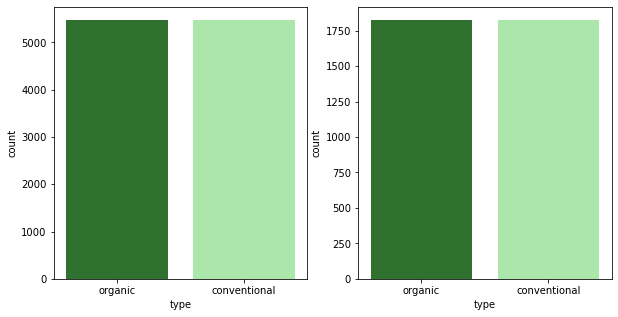

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.countplot(x='type', data=df_train, palette=["darkgreen", "lightgreen"], alpha=0.85, ax=axes[0]);
sns.countplot(x='type', data=df_val, palette=["darkgreen", "lightgreen"], alpha=0.85, ax=axes[1]);

**Notes:**
* The number of avocados per type is equally distributed

**Analyze PLUs**

In [41]:
df_train.head()

,date,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,region
0,2015-01-04,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
1,2015-01-04,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
2,2015-01-04,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
3,2015-01-04,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
4,2015-01-04,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


In [42]:
# Number of avocados per PLU 4046 (total_volume)
df_volume_per_4046_train = pd.DataFrame(df_train.groupby("type")["4046"].mean())
df_volume_per_4046_train.T

type,conventional,organic
4046,572354.643297,7900.37791


In [43]:
# Number of avocados per PLU 4046 (total_volume)
df_volume_per_4046_val = pd.DataFrame(df_val.groupby("type")["4046"].mean())
df_volume_per_4046_val.T

type,conventional,organic
4046,604015.298674,7134.726444


In [44]:
# Number of avocados per PLU 4225 (total_volume)
df_volume_per_4225_train = pd.DataFrame(df_train.groupby("type")["4225"].mean())
df_volume_per_4225_train.T

type,conventional,organic
4225,599384.712539,15144.551229


In [45]:
# Number of avocados per PLU 4225 (total_volume)
df_volume_per_4225_val = pd.DataFrame(df_val.groupby("type")["4225"].mean())
df_volume_per_4225_val.T

type,conventional,organic
4225,560321.344964,17393.982548


In [46]:
# Number of avocados per PLU 4770 (total_volume)
df_volume_per_4770_train = pd.DataFrame(df_train.groupby("type")["4770"].mean())
df_volume_per_4770_train.T

type,conventional,organic
4770,54351.877752,354.899646


In [47]:
# Number of avocados per PLU 4770 (total_volume)
df_volume_per_4770_val = pd.DataFrame(df_val.groupby("type")["4770"].mean())
df_volume_per_4770_val.T

type,conventional,organic
4770,35931.241244,199.890159


In [48]:
df_plu_train = pd.concat([df_volume_per_4046_train, df_volume_per_4225_train, df_volume_per_4770_train], axis=1)
df_plu_train

,4046,4225,4770
type,,,
conventional,572354.643297,599384.712539,54351.877752
organic,7900.377910,15144.551229,354.899646


In [49]:
df_plu_val = pd.concat([df_volume_per_4046_val, df_volume_per_4225_val, df_volume_per_4770_val], axis=1)
df_plu_val

,4046,4225,4770
type,,,
conventional,604015.298674,560321.344964,35931.241244
organic,7134.726444,17393.982548,199.890159


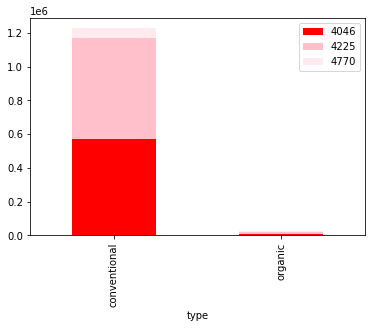

In [50]:
df_plu_train.plot(kind='bar', stacked=True, color=['red', 'pink', '#FFEBEE']);

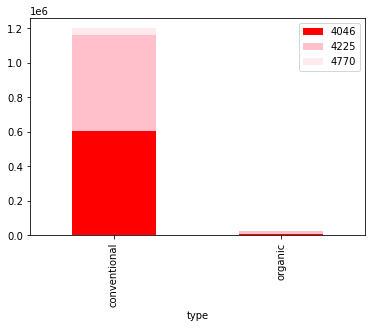

In [51]:
df_plu_val.plot(kind='bar', stacked=True, color=['red', 'pink', '#FFEBEE']);

**Vectorize Categorical Variables**

In [52]:
train_vars = ["total_bags","total_volume"] + categorical#numerical + categorical
train_vars

['total_bags', 'total_volume', 'type', 'region', 'year']

In [53]:
# scale numerical features
scaler = StandardScaler()
df_train_num = pd.DataFrame(scaler.fit_transform(df_train[["total_bags","total_volume"]]),
                         columns=["total_bags","total_volume"])
df_val_num = pd.DataFrame(scaler.transform(df_val[["total_bags","total_volume"]]),
                         columns=["total_bags","total_volume"])

In [54]:
df_train_num

,total_bags,total_volume
0,-0.224771,-0.237963
1,-0.240233,-0.240847
2,-0.238257,-0.245282
3,-0.223155,-0.229710
4,-0.240880,-0.245699
...,...,...
10944,-0.237722,-0.243730
10945,-0.005671,-0.144650
10946,0.152038,0.057747
10947,-0.195155,-0.220980


In [55]:
df_train_new = pd.concat([df_train[categorical], df_train_num], axis=1)
df_val_new = pd.concat([df_val[categorical], df_val_num], axis=1)
df_train = df_train_new
df_val = df_val_new

In [56]:
train_full_dicts = df_train_full[train_vars].to_dict(orient="records")
train_dicts = df_train[train_vars].to_dict(orient="records")
val_dicts = df_val[train_vars].to_dict(orient="records")
test_dicts = df_test[train_vars].to_dict(orient="records")

In [57]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Modeling

* Predicting the price is a regression problem
* Use RMSE as metric
* Compare the following models:
    * Linear Regression
    * Decision Tree
    * Random Forest
    * XGBoost
    * AdaBoost
* Baseline: Predict the mean (of the training data)

**Baseline**
* Always predict the mean average price 

In [58]:
base_pred = y_train.mean()
base_pred

1.3586007854598594

In [59]:
base_pred_vec = np.repeat(base_pred, len(y_val))

In [60]:
rmse_base = mean_squared_error(base_pred_vec, y_val, squared=False)
rmse_base

0.43973348563907255

**Note**
* The baseline metric is ```rmse=0.44```

**Train some models with standard parameters**
* note: xgb for regression can be used as sklearn models!

In [61]:
feature_names = dv.get_feature_names_out()
feature_names

array(['region=Albany', 'region=Atlanta', 'region=BaltimoreWashington',
       'region=Boise', 'region=Boston', 'region=BuffaloRochester',
       'region=California', 'region=Charlotte', 'region=Chicago',
       'region=CincinnatiDayton', 'region=Columbus',
       'region=DallasFtWorth', 'region=Denver', 'region=Detroit',
       'region=GrandRapids', 'region=GreatLakes',
       'region=HarrisburgScranton', 'region=HartfordSpringfield',
       'region=Houston', 'region=Indianapolis', 'region=Jacksonville',
       'region=LasVegas', 'region=LosAngeles', 'region=Louisville',
       'region=MiamiFtLauderdale', 'region=Midsouth', 'region=Nashville',
       'region=NewOrleansMobile', 'region=NewYork', 'region=Northeast',
       'region=NorthernNewEngland', 'region=Orlando',
       'region=Philadelphia', 'region=PhoenixTucson', 'region=Pittsburgh',
       'region=Plains', 'region=Portland', 'region=RaleighGreensboro',
       'region=RichmondNorfolk', 'region=Roanoke', 'region=Sacramento',
   

In [62]:
models = [LinearRegression(), 
          DecisionTreeRegressor(random_state=seed), 
          RandomForestRegressor(random_state=seed), 
          AdaBoostRegressor(random_state=seed),
          xgb.XGBRegressor(seed=seed)]

In [63]:
scores = {}
scores["train"] = {}
scores["val"] = {}
for model in models:
    name = model.__class__.__name__
    print(name)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_val)
    rmse_train = mean_squared_error(y_pred_train, y_train, squared=False)
    rmse_val = mean_squared_error(y_pred, y_val, squared=False)
    print(f"rmse training: {rmse_train:.3f}\t rmse validation: {rmse_val:.3f}")
    scores["train"][name] = (model, y_pred_train, rmse_train)
    scores["val"][name] = (model, y_pred, rmse_val)

LinearRegression
rmse training: 0.222	 rmse validation: 0.327
DecisionTreeRegressor
rmse training: 0.000	 rmse validation: 0.315
RandomForestRegressor
rmse training: 0.050	 rmse validation: 0.285
AdaBoostRegressor
rmse training: 0.260	 rmse validation: 0.344
XGBRegressor
rmse training: 0.098	 rmse validation: 0.278


**Scatterplots of Test and validation Set**

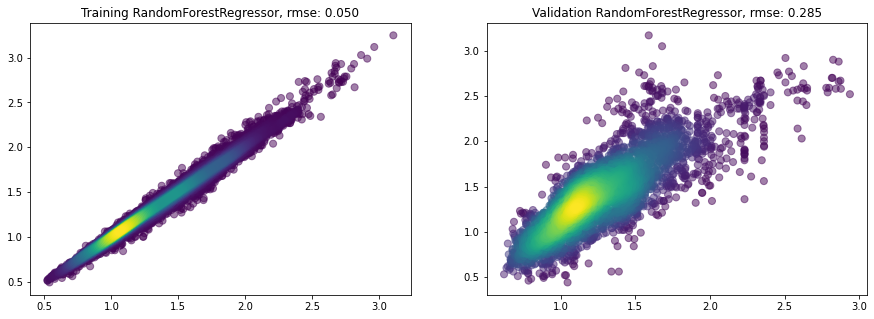

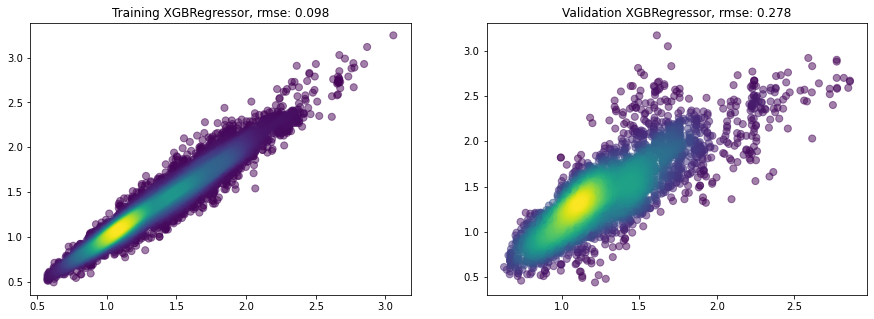

In [64]:
models = ['RandomForestRegressor', 'XGBRegressor']

for model in models:
    y_pred_train = scores["train"][model][1]
    rmse_train = scores["train"][model][2]
    y_pred = scores["val"][model][1]
    rmse_val = scores["val"][model][2]
    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    # Calculate the point density
    xy_train = np.vstack([y_pred_train, y_train])
    z_train = gaussian_kde(xy_train)(xy_train)
    xy_val = np.vstack([y_pred, y_val])
    z_val = gaussian_kde(xy_val)(xy_val)
    # Sort the points by density, so that the densest points are plotted last
    idx = z_train.argsort()
    y_pred_train_, y_train_, z_train_ = y_pred_train[idx], y_train[idx], z_train[idx]
    idx = z_val.argsort()
    y_pred_, y_val_, z_val_ = y_pred[idx], y_val[idx], z_val[idx]
    
    axes[0].scatter(y_pred_train_, y_train_, alpha=0.5, c=z_train_, s=50)
    axes[0].set_title(f"Training {model}, rmse: {rmse_train:.3f}")
    axes[1].scatter(y_pred_, y_val_, alpha=0.5, c=z_val_, s=50)
    axes[1].set_title(f"Validation {model}, rmse: {rmse_val:.3f}")
   
   

**Notes**
* With default paramters Random Forest and XGBoost are performing best
* Both are outperforming the baseline
* Both models are overfitting on the validation set
* Do hyperparametertuning of these two

## Hyperparameter Tuning
* Use Optuna for hyperparamter tuning 
* Use cross validation of the train_full dataset to optimize

In [65]:
X_train_full = dv.fit_transform(train_full_dicts)
X_test = dv.transform(test_dicts)

In [ ]:
def objective(trial):
    
    reg_name = trial.suggest_categorical("regressor", ["RandomForest", "XGB"])
    
    if reg_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)
        max_depth = trial.suggest_int('max_depth', 5, 100, step=5)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth, 
                                      min_samples_split=min_samples_split,
                                      n_jobs=-1)
    
    else:
        n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
        eta = trial.suggest_float('eta', 0.001, .03)
        gamma = trial.suggest_float('gamma', 0.01, .1, log=True)
        alpha = trial.suggest_float('alpha', 1e-8, 0.5, log=True)
        max_depth = trial.suggest_int('max_depth', 10, 50, step=5)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 15)
        
        model = xgb.XGBRegressor(n_estimators=n_estimators,
                             eta=eta,
                             gamma=gamma,
                             alpha=alpha,
                             max_depth=max_depth,
                             min_child_weight=min_child_weight,
                             nthread=8,
                             verbosity=1
                            )
        
    
    score = cross_val_score(model, X_train_full, y_train_full, 
                            n_jobs=-1, cv=5, 
                            scoring='neg_root_mean_squared_error')
    rmse = score.mean()
    return abs(rmse)

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params 

[I 2022-04-07 08:10:55,899] A new study created in memory with name: no-name-2e871e2c-e747-4d49-8b56-f2d12fdd19f0


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
## Final Model
# Create an instance with tuned hyperparameters
if study.best_params['regressor'] == 'RandomForest':
    optimised_model = RandomForestRegressor(max_depth = study.best_params['max_depth'], 
                                     min_samples_split = study.best_params['min_samples_split'],
                                     n_estimators = study.best_params['n_estimators'],
                                     n_jobs=-1)

else:
    optimised_model = xgb.XGBRegressor(n_estimators=study.best_params['n_estimators'],
                             eta=study.best_params['eta'],
                             gamma=study.best_params['gamma'],
                             alpha=study.best_params['alpha'],
                             max_depth=study.best_params['max_depth'],
                             min_child_weight=study.best_params['min_child_weight'],
                             nthread=8,
                             verbosity=1
                            )
    
optimised_model.fit(X_train_full ,y_train_full)

y_pred_train = optimised_model.predict(X_train_full)
y_pred = optimised_model.predict(X_test)
rmse_train = mean_squared_error(y_pred_train, y_train_full, squared=False)
rmse_val = mean_squared_error(y_pred, y_test, squared=False)
print(f"rmse training: {rmse_train:.3f}\t rmse test: {rmse_val:.3f}")
    

**Notes**

* Still overfitting (on test set even more!), more hyperparamter tuning or / and feature engineering would be necessary
* A general problem is that train / valid and test distributions differ (probably due to time)
* Higher number of estimators is difficult to test on personal laptop
* For the purpose of this exercise, I will keep this model, knowing it could propably still be improved

**Save the Model**

In [ ]:
reg = study.best_params['regressor'] 
if reg=='RandomForest':
    output_file=f"{reg}_n_est={study.best_params['n_estimators']}"\
            f"_max_depth={study.best_params['max_depth']}" \
            f"_min_sample_weight={study.best_params['min_samples_split']:.3f}.bin"
else:
    output_file=f"{reg}_n_est={study.best_params['n_estimators']}_eta={study.best_params['eta']:.3f}" \
            f"_gamma={study.best_params['gamma']:.3f}_alpha={study.best_params['alpha']:.3f}" \
            f"_max_depth={study.best_params['max_depth']}" \
            f"_min_child_weight={study.best_params['min_child_weight']:.3f}.bin"

In [ ]:
output_file

In [ ]:
with open(output_file, "wb") as f_out:
    # save model and vectorization
    pickle.dump((scaler, dv, optimized_model), f_out)